# LSTM Model for Reddit Post Virality Prediction (Author 1, Kundyz)

This notebook implements a Long Short-Term Memory (LSTM) network to predict Reddit post virality based on temporal patterns and sequential engagement.

## Objectives:
1. Load preprocessed data from data preparation notebook
2. Prepare sequences for LSTM input (text sequences, temporal sequences)
3. Design and implement LSTM architecture
4. Train the model with hyperparameter tuning
5. Evaluate model performance


## 1. Import Required Libraries


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn for preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.20.0
GPU Available: []


## 2. Load Preprocessed Data

Load the data prepared in the data preparation notebook.


In [13]:
# Load data from data directory
data_dir = Path('data')

# Load processed data
try:
    # Load feature matrix and labels
    X_features = np.load(data_dir / 'X_features.npy')
    y_labels = np.load(data_dir / 'y_labels.npy')
    text_data = np.load(data_dir / 'text_data.npy', allow_pickle=True)
    
    # Load metadata
    with open(data_dir / 'metadata.json', 'r') as f:
        metadata = json.load(f)
    
    print("✓ Data loaded successfully!")
    print(f"Feature matrix shape: {X_features.shape}")
    print(f"Labels shape: {y_labels.shape}")
    print(f"Text data shape: {text_data.shape}")
    print(f"\nMetadata:")
    print(f"  Number of features: {metadata['num_features']}")
    print(f"  Number of samples: {metadata['num_samples']}")
    print(f"  Viral posts: {metadata['viral_count']} ({metadata['viral_count']/metadata['num_samples']*100:.2f}%)")
    print(f"  Non-viral posts: {metadata['non_viral_count']} ({metadata['non_viral_count']/metadata['num_samples']*100:.2f}%)")
    
except FileNotFoundError as e:
    print(f"⚠ Error loading data: {e}")
    print("Please run the LSTM_data_preparation.ipynb notebook first to prepare the data.")
    raise


✓ Data loaded successfully!
Feature matrix shape: (56297, 15)
Labels shape: (56297,)
Text data shape: (56297,)

Metadata:
  Number of features: 15
  Number of samples: 56297
  Viral posts: 28149 (50.00%)
  Non-viral posts: 28148 (50.00%)


## 3. Prepare Sequences for LSTM

LSTM models require sequential input. We'll create sequences from:
1. **Text sequences**: Tokenized post content
2. **Temporal sequences**: Feature sequences over time windows
3. **Feature sequences**: Multi-dimensional feature sequences


In [14]:
# Parameters for sequence preparation (tuned for better performance)
MAX_SEQUENCE_LENGTH = 150   # more context per post (was 100)
MAX_VOCAB_SIZE = 5000       # keep vocab size reasonable
EMBEDDING_DIM = 128         # richer embeddings (was 64)
SEQUENCE_WINDOW = 5         # keep feature window small for speed

print("Preparing sequences for LSTM...")

# 1. Prepare text sequences
print("\n1. Processing text sequences...")
# Convert text data to strings
text_strings = [str(text) for text in text_data]

# Tokenize text
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(text_strings)
word_index = tokenizer.word_index
print(f"   Vocabulary size: {len(word_index)}")

# Convert texts to sequences
text_sequences = tokenizer.texts_to_sequences(text_strings)

# Pad sequences to fixed length
X_text = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
print(f"   Text sequences shape: {X_text.shape}")

# 2. Prepare feature sequences (create sliding windows)
print("\n2. Processing feature sequences...")
# Normalize features
scaler = StandardScaler()
X_features_scaled = scaler.fit_transform(X_features)

# Create sequences from features (using sliding window approach)
def create_feature_sequences(features, window_size=SEQUENCE_WINDOW):
    """Create sequences from feature matrix using sliding window"""
    sequences = []
    for i in range(len(features)):
        # For each sample, create a sequence by repeating features (simulating temporal progression)
        # In a real scenario, you'd have actual temporal data
        seq = np.tile(features[i], (window_size, 1))
        sequences.append(seq)
    return np.array(sequences)

X_features_seq = create_feature_sequences(X_features_scaled, window_size=SEQUENCE_WINDOW)
print(f"   Feature sequences shape: {X_features_seq.shape}")

# 3. Combine text and feature sequences
print("\n3. Combining sequences...")
# For hybrid model: use both text and feature sequences
# We'll create a model that processes both inputs

print(f"\n✓ Sequence preparation complete!")
print(f"   Text sequences: {X_text.shape}")
print(f"   Feature sequences: {X_features_seq.shape}")
print(f"   Labels: {y_labels.shape}")


Preparing sequences for LSTM...

1. Processing text sequences...
   Vocabulary size: 28920
   Text sequences shape: (56297, 150)

2. Processing feature sequences...
   Feature sequences shape: (56297, 5, 15)

3. Combining sequences...

✓ Sequence preparation complete!
   Text sequences: (56297, 150)
   Feature sequences: (56297, 5, 15)
   Labels: (56297,)


## 4. Split Data into Train/Validation/Test Sets


In [15]:
# Split data: 70% train, 15% validation, 15% test
X_text_temp, X_text_test, X_feat_temp, X_feat_test, y_temp, y_test = train_test_split(
    X_text, X_features_seq, y_labels, test_size=0.15, random_state=42, stratify=y_labels
)

X_text_train, X_text_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_text_temp, X_feat_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # 0.176 ≈ 15/85
)

print("Data split:")
print(f"  Training set:   {X_text_train.shape[0]} samples ({X_text_train.shape[0]/len(y_labels)*100:.1f}%)")
print(f"  Validation set: {X_text_val.shape[0]} samples ({X_text_val.shape[0]/len(y_labels)*100:.1f}%)")
print(f"  Test set:       {X_text_test.shape[0]} samples ({X_text_test.shape[0]/len(y_labels)*100:.1f}%)")

print(f"\nClass distribution:")
print(f"  Train - Viral: {y_train.sum()}, Non-viral: {(y_train == 0).sum()}")
print(f"  Val   - Viral: {y_val.sum()}, Non-viral: {(y_val == 0).sum()}")
print(f"  Test  - Viral: {y_test.sum()}, Non-viral: {(y_test == 0).sum()}")


Data split:
  Training set:   39430 samples (70.0%)
  Validation set: 8422 samples (15.0%)
  Test set:       8445 samples (15.0%)

Class distribution:
  Train - Viral: 19715, Non-viral: 19715
  Val   - Viral: 4211, Non-viral: 4211
  Test  - Viral: 4223, Non-viral: 4222


## 5. Build LSTM Model Architecture

We'll create a hybrid LSTM model that processes both text sequences and feature sequences.


In [16]:
def build_lstm_model(vocab_size, embedding_dim, max_seq_length, feature_seq_shape, lstm_units=64, dropout_rate=0.2):
    """
    Build a hybrid LSTM model that processes both text and feature sequences
    
    Args:
        vocab_size: Vocabulary size for text embedding
        embedding_dim: Dimension of word embeddings
        max_seq_length: Maximum length of text sequences
        feature_seq_shape: Shape of feature sequences (window_size, num_features)
        lstm_units: Number of LSTM units
        dropout_rate: Dropout rate for regularization
    """
    
    # Input 1: Text sequences
    text_input = layers.Input(shape=(max_seq_length,), name='text_input')
    text_embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_seq_length)(text_input)
    text_lstm = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)
    )(text_embedding)
    text_lstm2 = layers.Bidirectional(
        layers.LSTM(lstm_units // 2, return_sequences=False, dropout=dropout_rate)
    )(text_lstm)
    text_dropout = layers.Dropout(dropout_rate)(text_lstm2)
    
    # Input 2: Feature sequences
    feature_input = layers.Input(shape=feature_seq_shape[1:], name='feature_input')
    feature_lstm = layers.LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)(feature_input)
    feature_lstm2 = layers.LSTM(lstm_units // 2, return_sequences=False, dropout=dropout_rate)(feature_lstm)
    feature_dropout = layers.Dropout(dropout_rate)(feature_lstm2)
    
    # Concatenate both branches
    concatenated = layers.Concatenate()([text_dropout, feature_dropout])
    
    # Dense layers
    dense1 = layers.Dense(128, activation='relu')(concatenated)
    dense1_dropout = layers.Dropout(dropout_rate)(dense1)
    dense2 = layers.Dense(64, activation='relu')(dense1_dropout)
    dense2_dropout = layers.Dropout(dropout_rate)(dense2)
    
    # Output layer (binary classification)
    output = layers.Dense(1, activation='sigmoid', name='output')(dense2_dropout)
    
    # Create model
    model = models.Model(inputs=[text_input, feature_input], outputs=output)
    
    return model

# Build model
vocab_size = min(MAX_VOCAB_SIZE, len(word_index) + 1)
model = build_lstm_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    feature_seq_shape=X_features_seq.shape,
    lstm_units=64,   # reduced from 128 for speed
    dropout_rate=0.2  # matches function default
)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0007),  # slightly lower LR for more stable training
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture
print("Model Architecture:")
model.summary()

# Visualize model (optional)
try:
    keras.utils.plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)
    print("\n✓ Model architecture diagram saved to lstm_model_architecture.png")
except:
    print("\n⚠ Could not generate model diagram (graphviz not installed)")


Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 150, 128)  │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 5, 15)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 150, 128)  │     98,816 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 5, 64)     │     20,480 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     41,216 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 32)        │     12,416 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     12,416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 833,665 (3.18 MB)

 Trainable params: 833,665 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.

✓ Model architecture diagram saved to lstm_model_architecture.png


## 6. Train the Model

Train the LSTM model with callbacks for early stopping and learning rate reduction.


In [17]:
# Ensure data directory exists for saving checkpoints
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        str(data_dir / 'best_lstm_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Training parameters (tuned for slightly better performance)
BATCH_SIZE = 128  # keep larger batch for speed
EPOCHS = 15       # allow more epochs; early stopping will stop when needed

print("Starting training...")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Training samples: {len(y_train)}")
print(f"Validation samples: {len(y_val)}")

# Train model
history = model.fit(
    [X_text_train, X_feat_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_text_val, X_feat_val], y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n Training complete!")


Starting training...
Batch size: 128
Max epochs: 15
Training samples: 39430
Validation samples: 8422


Epoch 1/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8009 - loss: 0.4614 - precision: 0.7942 - recall: 0.8095
Epoch 1: val_loss improved from None to 0.41614, saving model to data\best_lstm_model.h5


309/309 ━━━━━━━━━━━━━━━━━━━━ 248s 743ms/step - accuracy: 0.8078 - loss: 0.4257 - precision: 0.8071 - recall: 0.8090 - val_accuracy: 0.8054 - val_loss: 0.4161 - val_precision: 0.8003 - val_recall: 0.8138 - learning_rate: 7.0000e-04
Epoch 2/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.8158 - loss: 0.4047 - precision: 0.8164 - recall: 0.8117
Epoch 2: val_loss did not improve from 0.41614
309/309 ━━━━━━━━━━━━━━━━━━━━ 212s 684ms/step - accuracy: 0.8149 - loss: 0.4018 - precision: 0.8133 - recall: 0.8174 - val_accuracy: 0.8002 - val_loss: 0.4219 - val_precision: 0.8005 - val_recall: 0.7996 - learning_rate: 7.0000e-04
Epoch 3/15
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.8249 - loss: 0.3803 - precision: 0.8215 - recall: 0.8268
Epoch 3: val_loss did not improve from 0.41614
309/309 ━━━━━━━━━━━━━━━━━━━━ 218s 704ms/step - accuracy: 0.8275 - loss: 0.3698 - precision: 0.8229 - recall: 0.8346 - val_accuracy: 0.7890 - val_loss: 0.4524 - val_precision: 0.7695 - val_recall

## 7. Visualize Training History


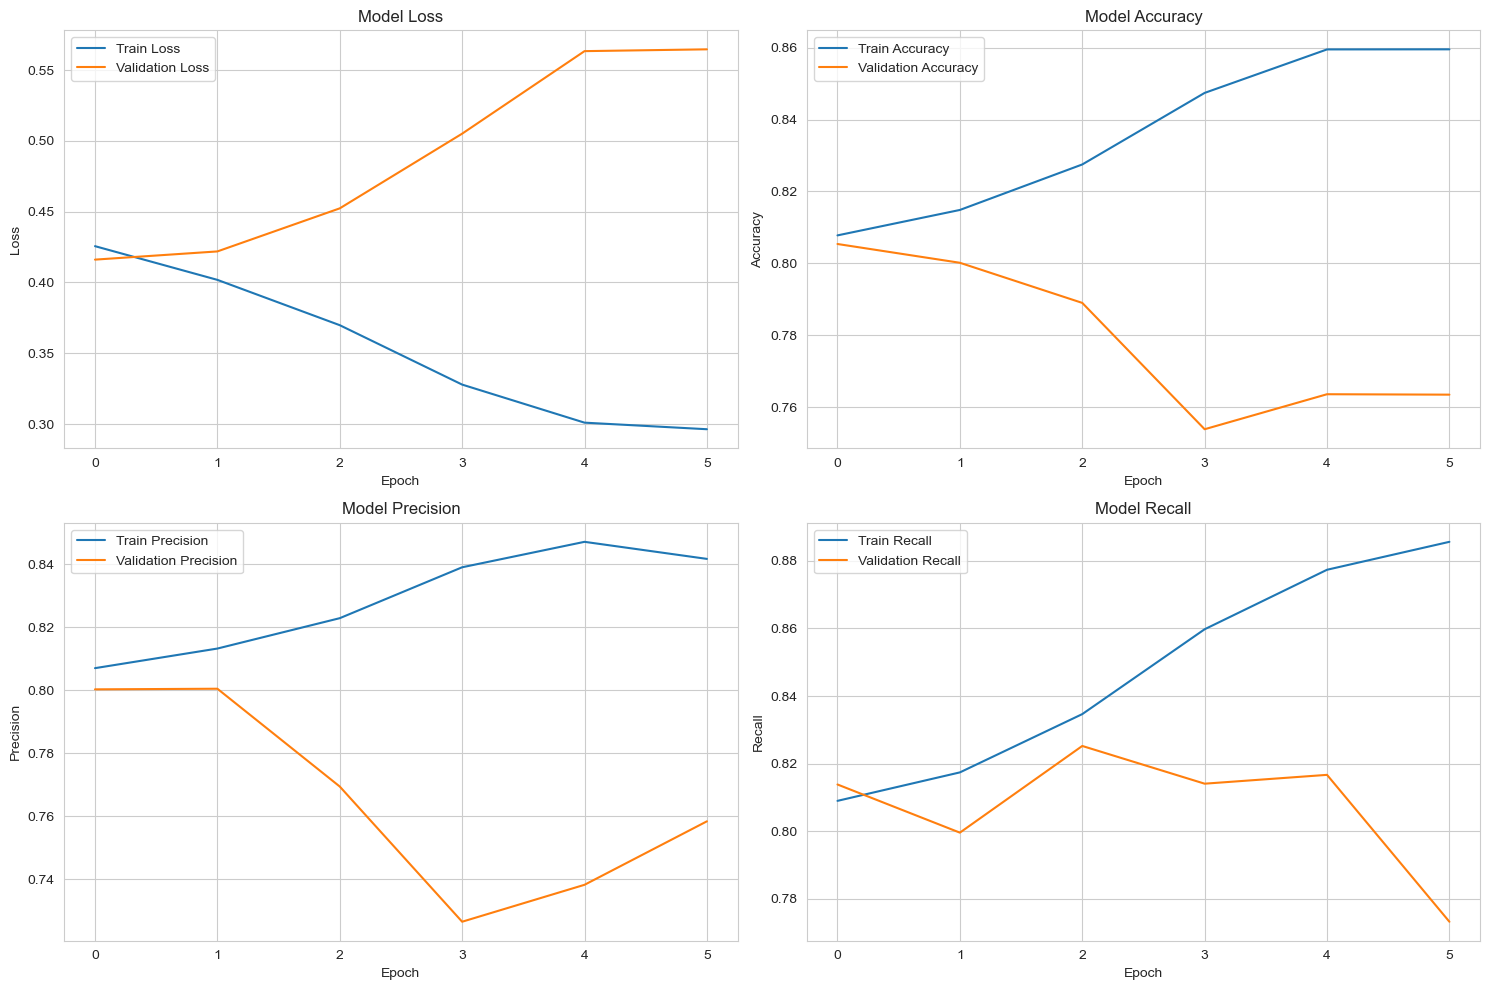


Best validation loss: 0.4161 at epoch 1
Best validation accuracy: 0.8054
Best validation precision: 0.8005
Best validation recall: 0.8252


In [18]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print best metrics
best_val_loss_idx = np.argmin(history.history['val_loss'])
print(f"\nBest validation loss: {history.history['val_loss'][best_val_loss_idx]:.4f} at epoch {best_val_loss_idx + 1}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Best validation precision: {max(history.history['val_precision']):.4f}")
print(f"Best validation recall: {max(history.history['val_recall']):.4f}")


## 8. Evaluate Model on Test Set

Evaluate the trained model on the test set and generate comprehensive metrics.


 Loaded best model weights

Evaluating on test set...

Test Metrics:
  Loss:     0.4058
  Accuracy: 0.8079
  Precision: 0.8014
  Recall:   0.8188

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Not Viral       0.81      0.80      0.81      4222
       Viral       0.80      0.82      0.81      4223

    accuracy                           0.81      8445
   macro avg       0.81      0.81      0.81      8445
weighted avg       0.81      0.81      0.81      8445


CONFUSION MATRIX
[[3365  857]
 [ 765 3458]]


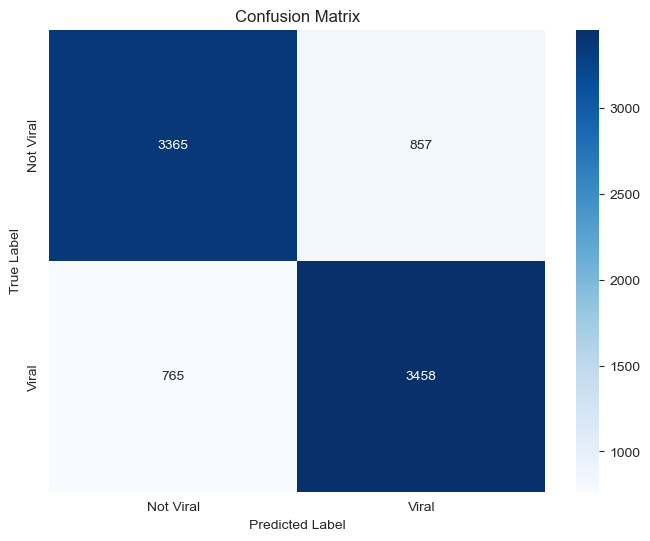


ROC-AUC Score: 0.8967


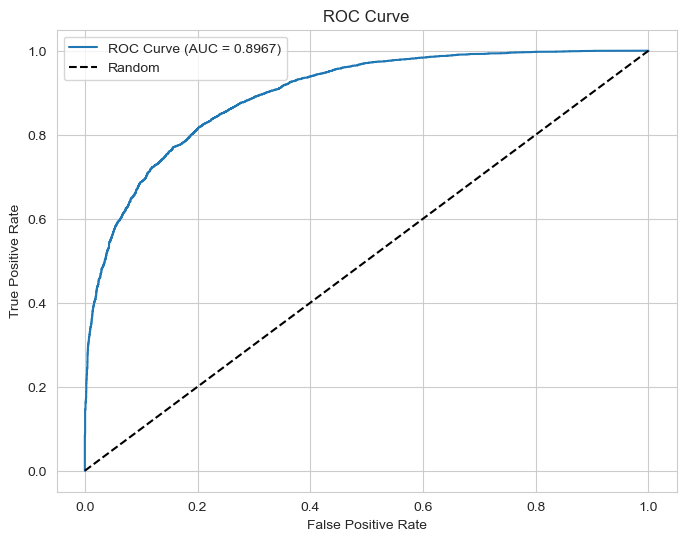

In [19]:
# Load best model
try:
    model.load_weights('data/best_lstm_model.h5')
    print(" Loaded best model weights")
except:
    print("⚠ Using current model weights")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    [X_text_test, X_feat_test],
    y_test,
    verbose=0
)

print(f"\nTest Metrics:")
print(f"  Loss:     {test_loss:.4f}")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:   {test_recall:.4f}")

# Predictions
y_pred_proba = model.predict([X_text_test, X_feat_test], verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Not Viral', 'Viral']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Viral', 'Viral'],
            yticklabels=['Not Viral', 'Viral'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


## 9. Save Model and Results

Save the trained model, tokenizer, scaler, and evaluation results.


In [21]:
# Ensure data directory exists
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Save model
model.save(data_dir / 'lstm_virality_model.h5')
print(f"Model saved to: {data_dir / 'lstm_virality_model.h5'}")

# Save tokenizer
import pickle
with open(data_dir / 'tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved to: {data_dir / 'tokenizer.pkl'}")

# Save scaler
with open(data_dir / 'feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"Feature scaler saved to: {data_dir / 'feature_scaler.pkl'}")

# Save evaluation results
results = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_roc_auc': float(roc_auc),
    'confusion_matrix': cm.tolist(),
    'model_parameters': {
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'embedding_dim': EMBEDDING_DIM,
        'sequence_window': SEQUENCE_WINDOW,
        'batch_size': BATCH_SIZE,
        'epochs_trained': len(history.history['loss'])
    }
}

with open(data_dir / 'lstm_model_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to: {data_dir / 'lstm_model_results.json'}")

print("\n All files saved successfully!")


Model saved to: data\lstm_virality_model.h5
Tokenizer saved to: data\tokenizer.pkl
Feature scaler saved to: data\feature_scaler.pkl
Results saved to: data\lstm_model_results.json

 All files saved successfully!
